In [13]:
# libraries
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

from IPython.display import display
from numpy import where
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.svm import OneClassSVM
import operator

In [14]:
# Constants
TRAINING_YEAR = 2015
TESTING_YEAR = 2017
ATTRIBUTE_SIZE = 8

In [15]:
# We might not need player_data.csv and players.csv since they are personal information that we can not make use of
salary_20 = pd.read_csv("salary_0020.csv")
salary_17 = pd.read_csv("salary_1718.csv")
stats = pd.read_csv("1950/seasons_stats.csv")
stats = stats.drop(stats.columns[0], axis=1)
pd.set_option('display.max_columns', None)


# Append salary to the dataframe
# Use the following attributes to fit models
# age, G, GS, MP, PER, TS, FTr, ORB%, DRB%, TRB%, AST%  STL%  BLK% TOV%  USG%, OWS  DWS, WS  WS/48, VORP, OBPM  DBPM  BPM and everything afterwards

team_names = {
    "Atlanta Hawks":"ATL",
    "Boston Celtics":"BOS",
    "Brooklyn Nets":"BKN",
    "Charlotte Hornets":"CHA",
    "Charlotte Bobcats":"CHB",
    "Chicago Bulls":"CHI",
    "Cleveland Cavaliers":"CLE",
    "Dallas Mavericks":"DAL",
    "Denver Nuggets":"DEN",
    "Detroit Pistons":"DET",
    "Golden State Warriors":"GSW",
    "Houston Rockets":"HOU",
    "Indiana Pacers":"IND",
    "LA Clippers":"LAC",
    "Los Angeles Clippers": "LAC",
    "Los Angeles Lakers":"LAL",
    "Memphis Grizzlies":"MEM",
    "Miami Heat":"MIA",
    "Milwaukee Bucks":"MIL",
    "Minnesota Timberwolves":"MIN",
    "New Orleans Pelicans":"NOP",
    "New York Knicks":"NYK",
    "Oklahoma City Thunder":"OKC",
    "Orlando Magic":"ORL",
    "Philadelphia 76ers":"PHI",
    "Phoenix Suns":"PHX",
    "Portland Trail Blazers":"POR",
    "Sacramento Kings":"SAC",
    "San Antonio Spurs":"SAS",
    "Toronto Raptors":"TOR",
    "Utah Jazz":"UTA",
    "Washington Wizards":"WAS",
    "Seattle SuperSonics":"SEA",
    "Vancouver Grizzlies":"VAN",
    "New Jersey Nets":"NJN",
    "New Orleans Hornets":"NOK",
}

unknowns = [
    'Madrid Real Madrid',
    "null Unknown",
    "NO/Oklahoma City Hornets",
    'Bilbao Basket Bilbao Basket',
    "Fenerbahce Ulker Fenerbahce Ulker",
    "Maccabi Haifa Maccabi Haifa"
]

# Convert team names in 0020 dataset to abbreviations
for i in range(len(salary_20)):
    v = salary_20['team'][i]
    if v in unknowns:
        continue
    salary_20.loc[i,'team'] = team_names[v]

# Remove unknowns
for v in unknowns:
    salary_20 = salary_20[salary_20['team'] != v]

# Only use players from 2000 onward
stats = stats[stats['Year'] >= 2000]


# Add salary to stats dataset based on player, year
merged_00_to_17 = stats.merge(salary_20, left_on=['Year', 'Player', 'Tm'], right_on=['season', 'name', 'team'])

# Drop unused columns that we think are irrelevant from merged dataset
merged_00_to_17 = merged_00_to_17.drop(columns = ['Player', 'Pos', 'Tm', '3PAr', 'blanl', 'blank2', 'rank', 'position', 'team', 'name', 'season'])

# Replace Nan with 0
merged_00_to_17.fillna(0, inplace=True)

# display(salary_20.head(10))

# display(stats.head(10))

# display(merged_00_to_17.head(10))

# display(merged_00_to_17.tail(10))

# Different datasets to see what produces best predictions
# Can either always predict later year or split train, test throughout years

merged_10_to_17 = merged_00_to_17[merged_00_to_17['Year'] >= 2010]

merged_13_to_17 = merged_00_to_17[merged_00_to_17['Year'] >= 2013]

# Using 16 to predict 17

merged_16_17 = merged_00_to_17[merged_00_to_17['Year'] >= 2016]

# Split within year

merged_17 = merged_00_to_17[merged_00_to_17['Year'] >= 2017]

Visualize correlation using Heatmap

<Axes: >

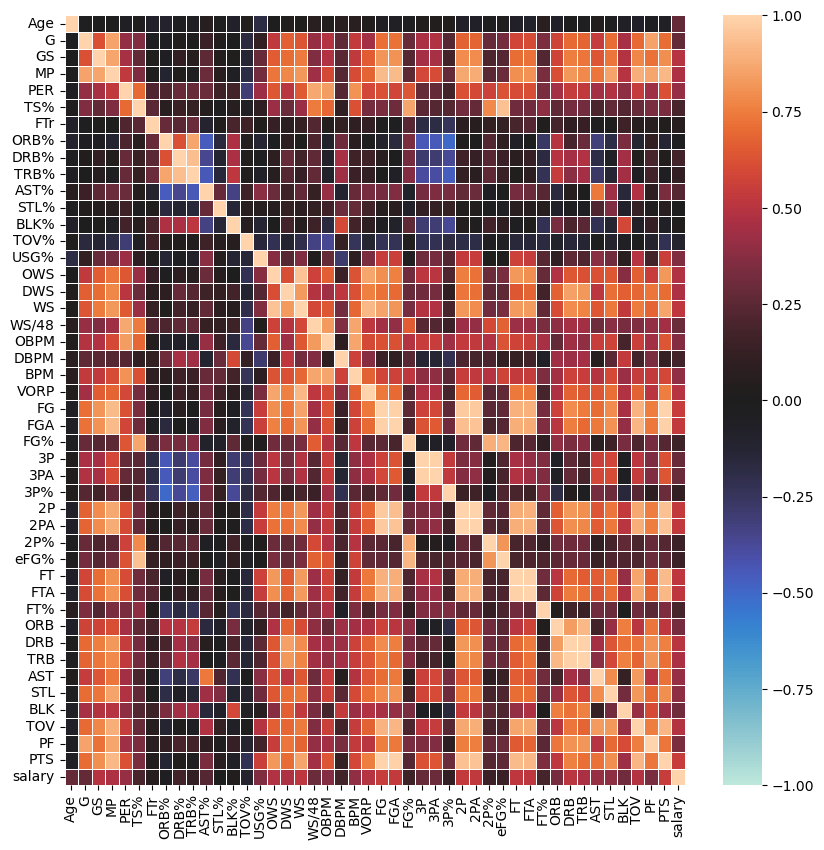

In [16]:
# heatmap for correlation
fig, ax = plt.subplots(figsize=(10, 10))

sb.heatmap(merged_00_to_17.drop(['Year'], axis = 1).corr(), vmin=-1, vmax=1, center= 0, linewidths=.5, xticklabels=True, yticklabels=True)

In [17]:
# Obtain the most relevant attributes
filtered_0017 =  merged_00_to_17.drop(['Year'], axis=1)

# Only need the salary column, and take out the correlation with salary itself
correlation = abs(filtered_0017.corr()['salary'][:-1])

# Get the sorted index of correlation
attribute_rank = np.argsort(correlation)

# Get the most relevant attributes
relevant_attributes = attribute_rank.index[attribute_rank[-ATTRIBUTE_SIZE:]]
print(relevant_attributes)

Index(['FT', 'FTA', 'WS', '2PA', 'FGA', '2P', 'PTS', 'FG'], dtype='object')


Outlier threshold: 12252135.5


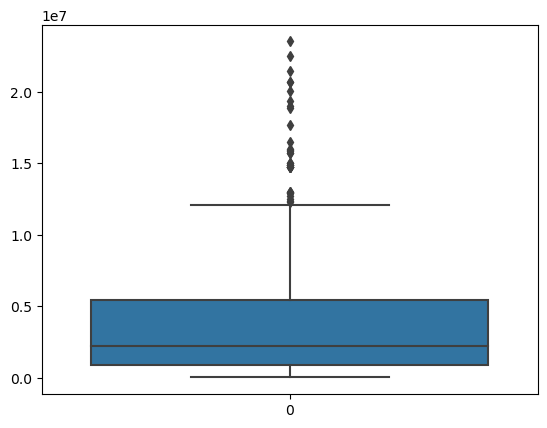

In [18]:
# Filter out some outliers in order to make better predictions
data = merged_00_to_17[merged_00_to_17['Year'] == TRAINING_YEAR]
data = data.drop(['Year'], axis=1)

# Max is usually calculated by Q3 + 1.5 * IQR, where IQR = Q3 - Q1
q3, q1 = np.quantile(data['salary'], [0.75, 0.25])
local_max = q3 + 1.5 * (q3 - q1)
data = data.reset_index(drop=True)
sb.boxplot(data['salary'])
print("Outlier threshold:",local_max)

# Get rid of outliers
data = data[data['salary'] <= local_max]

In [19]:
df_salary = data.copy()
# df_salary = pd.DataFrame(preprocessing.OrdinalEncoder().fit_transform(df_salary), columns=df_salary.columns)
# OrdinalEncoder will skip numerical values. LabelEncoder also works as they share the same functionality.
display(df_salary[relevant_attributes])

,FT,FTA,WS,2PA,FGA,2P,PTS,FG
0,76.0,97.0,1.7,271.0,331.0,134.0,398.0,152.0
1,14.0,23.0,0.4,61.0,86.0,25.0,94.0,35.0
2,103.0,205.0,4.1,397.0,399.0,217.0,537.0,217.0
3,22.0,38.0,0.4,44.0,44.0,19.0,60.0,19.0
4,40.0,47.0,0.8,137.0,227.0,58.0,264.0,94.0
...,...,...,...,...,...,...,...,...
407,34.0,42.0,1.6,82.0,190.0,31.0,219.0,72.0
408,120.0,180.0,0.3,292.0,434.0,138.0,507.0,175.0
409,16.0,29.0,0.3,36.0,102.0,19.0,105.0,36.0
410,132.0,148.0,1.2,251.0,476.0,91.0,563.0,174.0


In [20]:
salary_train, salary_test = train_test_split(df_salary, test_size=0.2)
X_salary_train, y_salary_train = salary_train[relevant_attributes], salary_train['salary']
X_salary_test, y_salary_test = salary_test[relevant_attributes], salary_test['salary']
print(df_salary)

      Age     G    GS      MP   PER    TS%    FTr  ORB%  DRB%  TRB%  AST%  \
0    24.0  68.0  22.0  1287.0  11.9  0.533  0.293   6.9  20.5  13.5   8.7   
1    20.0  30.0   0.0   248.0  12.8  0.489  0.267   4.2   8.7   6.4  10.1   
2    21.0  70.0  67.0  1771.0  14.1  0.549  0.514  12.2  19.3  15.8   5.5   
3    28.0  17.0   0.0   215.0  14.2  0.494  0.864  11.9  29.6  20.5  10.5   
4    29.0  25.0  19.0   752.0   8.2  0.533  0.207   0.9   8.5   4.8   5.5   
..    ...   ...   ...     ...   ...    ...    ...   ...   ...   ...   ...   
407  29.0  48.0   2.0   592.0  13.4  0.525  0.221   2.6  17.2  10.0  10.2   
408  21.0  30.0  15.0   895.0  14.9  0.494  0.415   2.5   8.1   5.2  34.9   
409  19.0  31.0   0.0   332.0   8.5  0.457  0.284   2.9  11.0   6.9   5.6   
410  29.0  42.0   0.0  1000.0  14.2  0.520  0.311   1.8   9.1   5.3   6.9   
411  25.0  82.0  59.0  1731.0  18.9  0.594  0.300   9.1  20.5  14.7  10.8   

     STL%  BLK%  TOV%  USG%  OWS  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP  \

In [21]:
print(X_salary_train)

        FT    FTA    WS    2PA     FGA     2P     PTS     FG
129  202.0  291.0   4.6  938.0  1165.0  452.0  1313.0  521.0
204  315.0  365.0  10.4  857.0  1235.0  421.0  1628.0  578.0
27    58.0   74.0   2.8  274.0   386.0  140.0   467.0  183.0
31    74.0   95.0   4.3  248.0   624.0  141.0   764.0  277.0
18    15.0   22.0   1.2   62.0    62.0   36.0    87.0   36.0
..     ...    ...   ...    ...     ...    ...     ...    ...
178  193.0  245.0   4.8  710.0   949.0  355.0  1164.0  442.0
212    1.0    1.0   0.1    7.0     9.0    4.0     9.0    4.0
145   63.0   78.0   1.3  335.0   511.0  142.0   533.0  204.0
341   61.0   77.0   2.7  261.0   453.0  135.0   529.0  201.0
96   227.0  252.0   3.6  475.0   839.0  213.0  1010.0  332.0

[302 rows x 8 columns]



Degree: 1
Training RMSE: 2407419.5609724335
Testing RMSE: 2705612.662307491
Training R2: -1.2387714003078423
Testing R2: -2.3718470454787552


FT



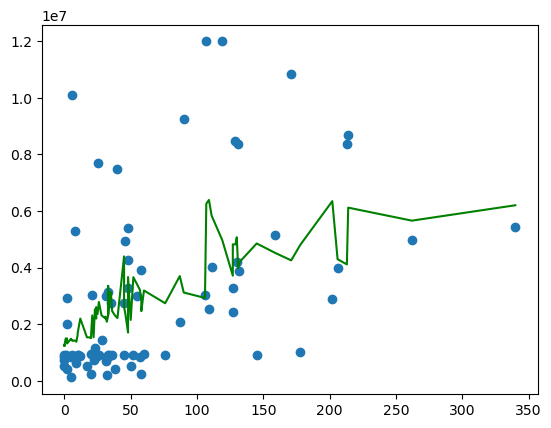


FTA



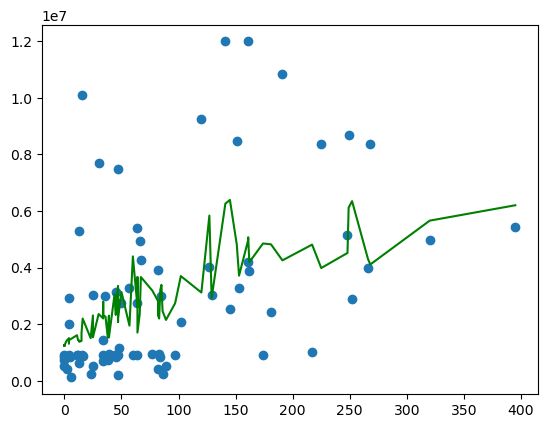


WS



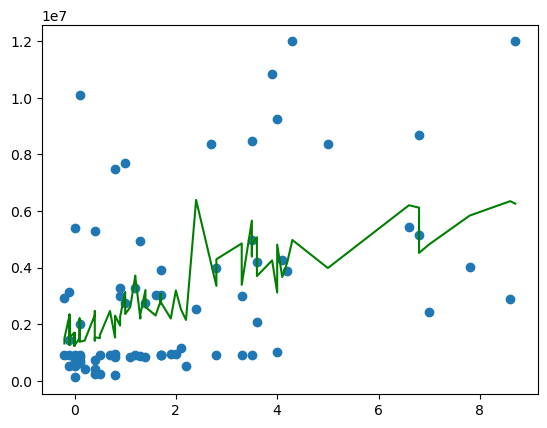


2PA



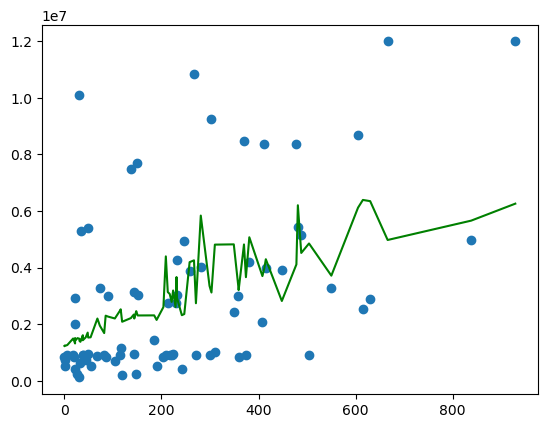


FGA



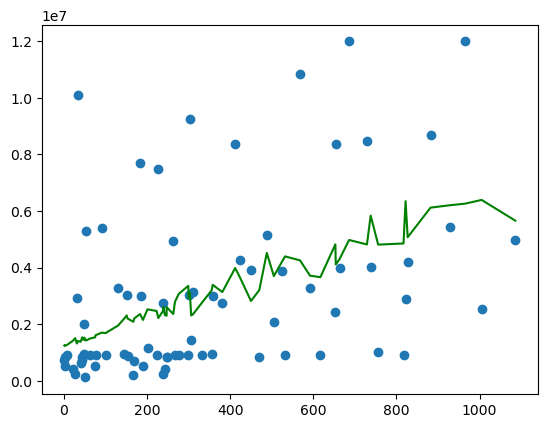


2P



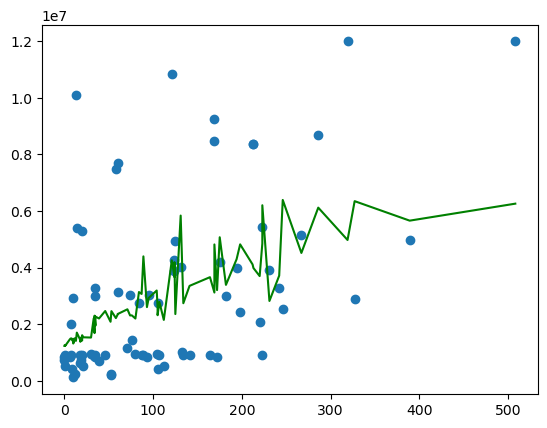


PTS



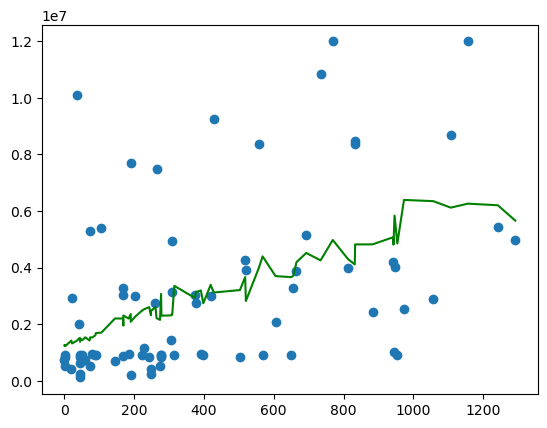


FG



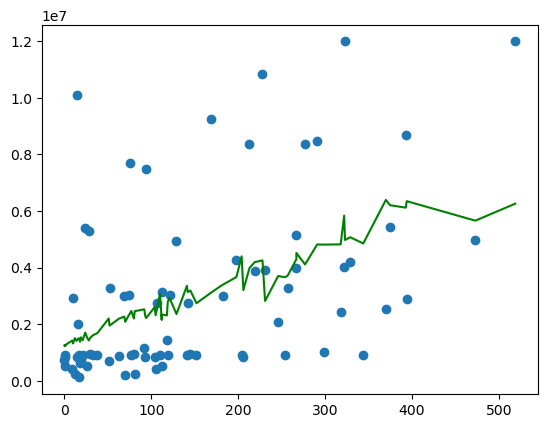


Degree: 2
Training RMSE: 2249745.1794534884
Testing RMSE: 2656264.5233822525
Training R2: -0.5231088059536297
Testing R2: -0.9247763542228475


FT



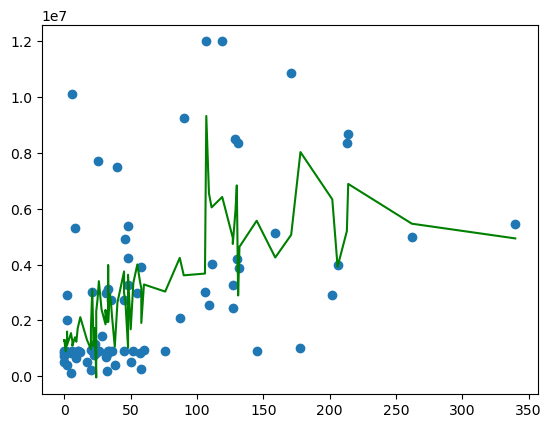


FTA



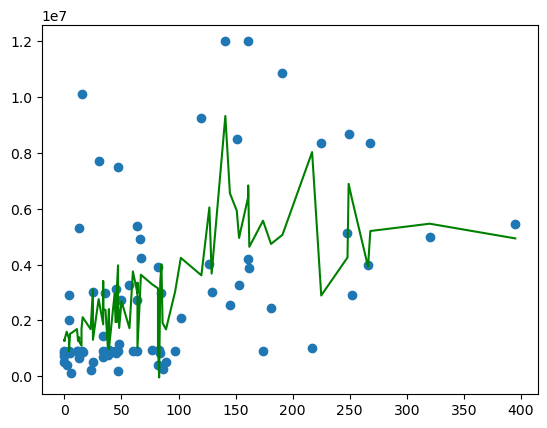


WS



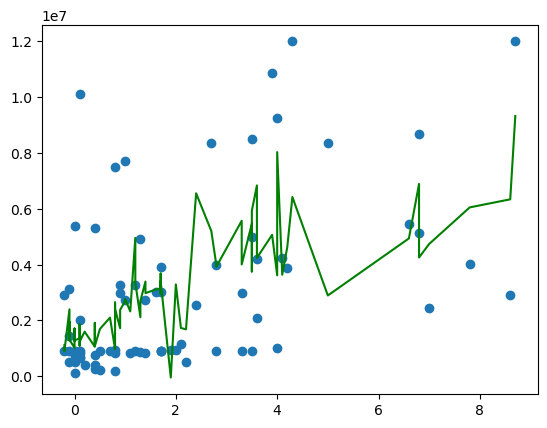


2PA



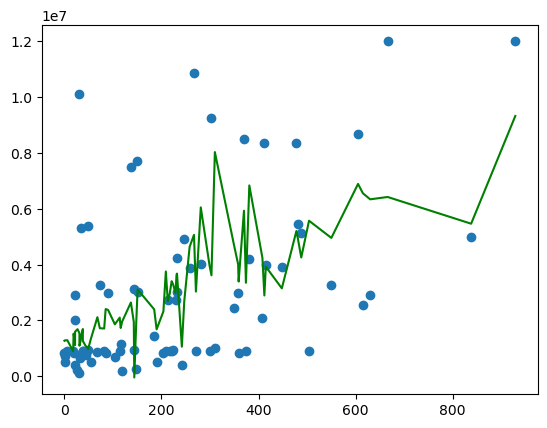


FGA



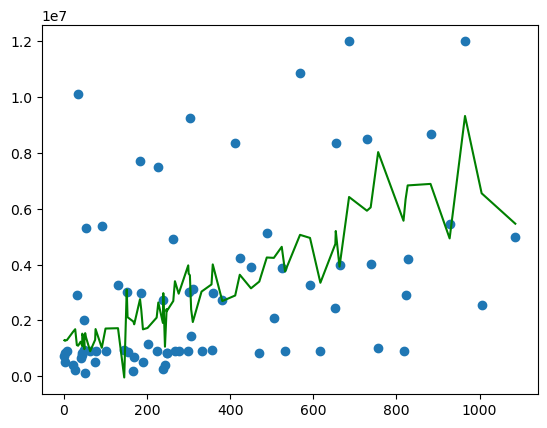


2P



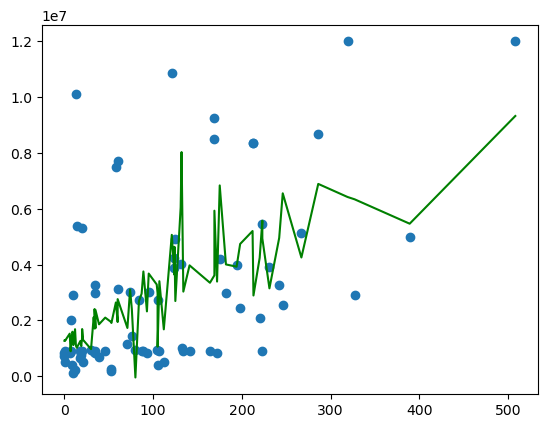


PTS



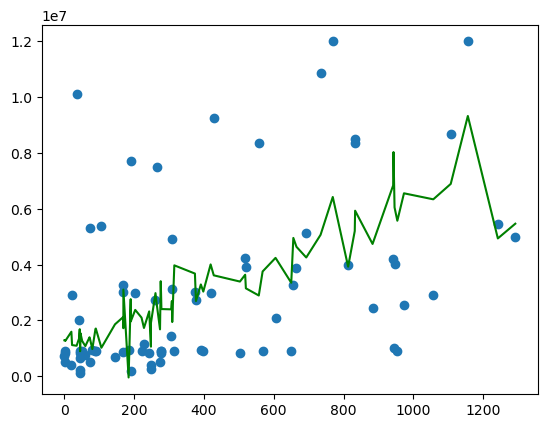


FG



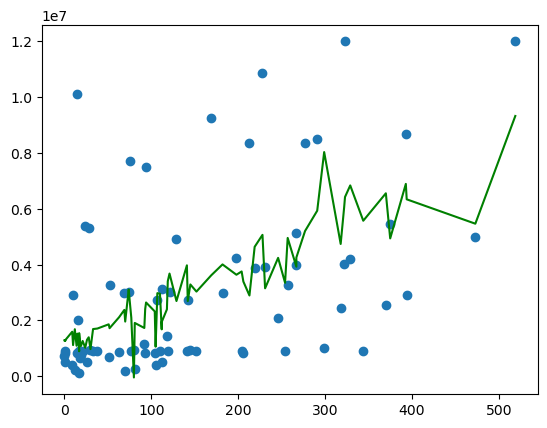


Degree: 3
Training RMSE: 1659090.9121877525
Testing RMSE: 9485652.962552518
Training R2: 0.5113020859986583
Testing R2: -0.042836408032776774


FT



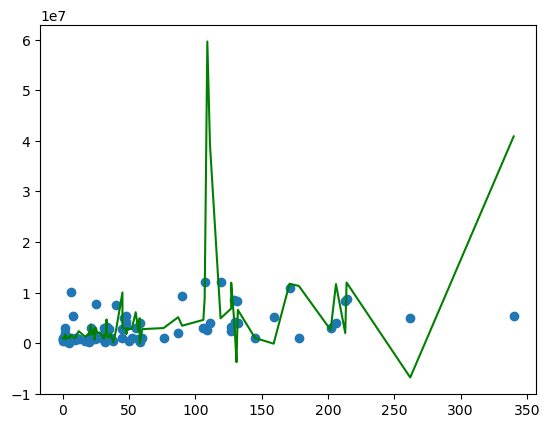


FTA



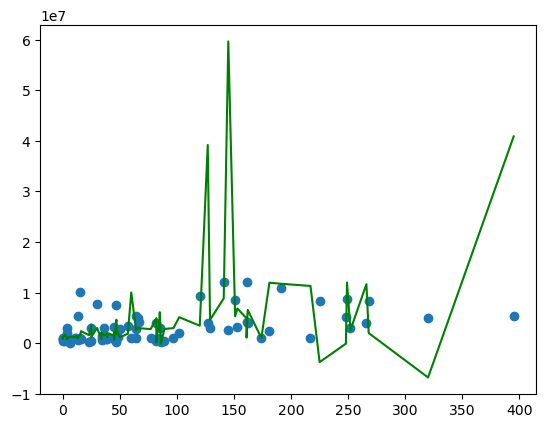


WS



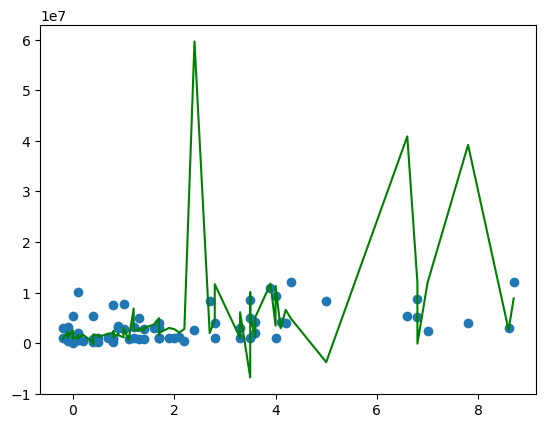


2PA



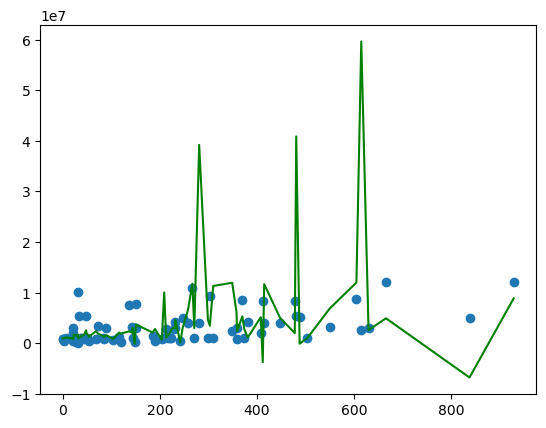


FGA



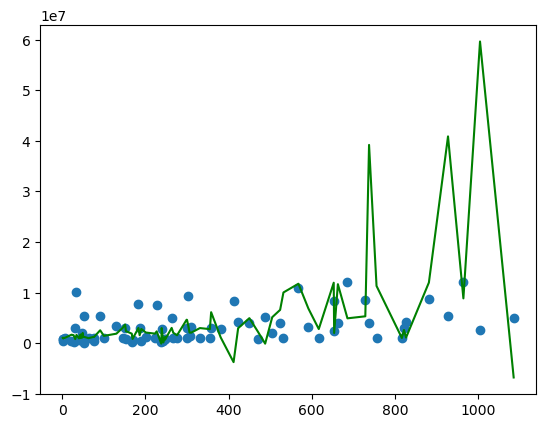


2P



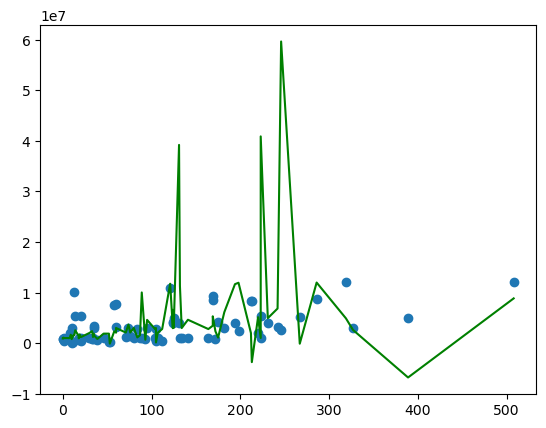


PTS



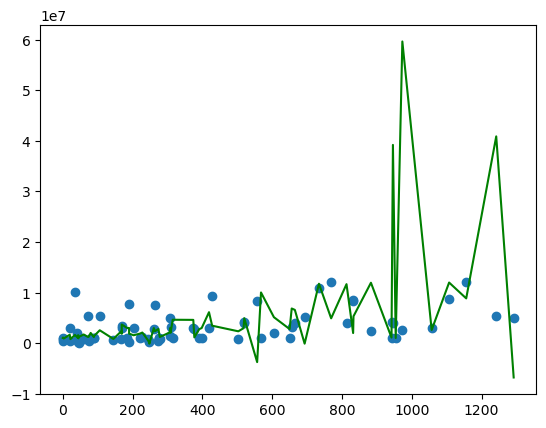


FG



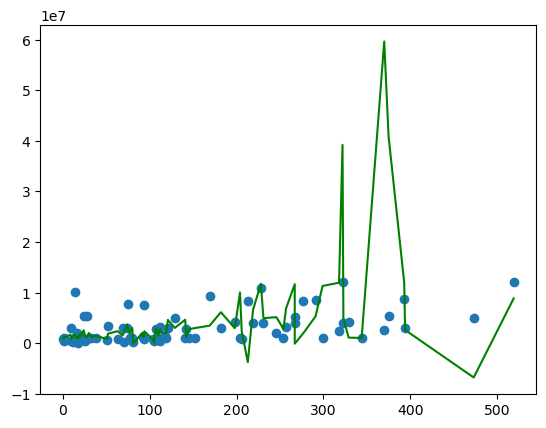


Degree: 4
Training RMSE: 7185.606007113335
Testing RMSE: 213105168762.1147
Training R2: 0.9999938416248652
Testing R2: -0.02828874846050833


FT



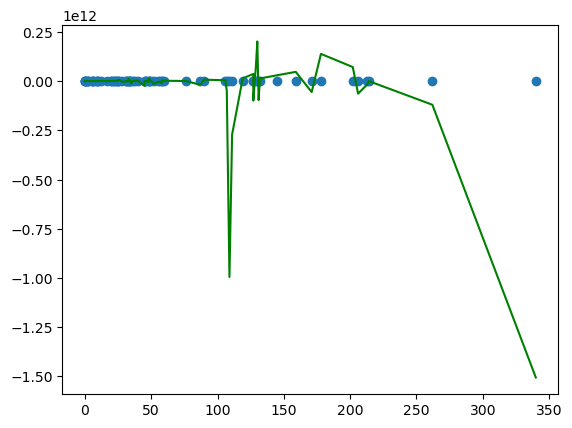


FTA



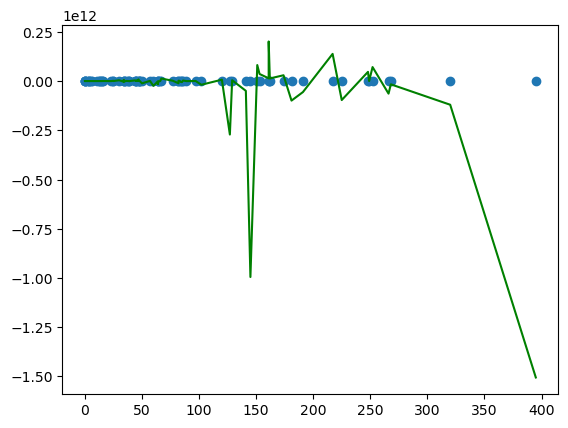


WS



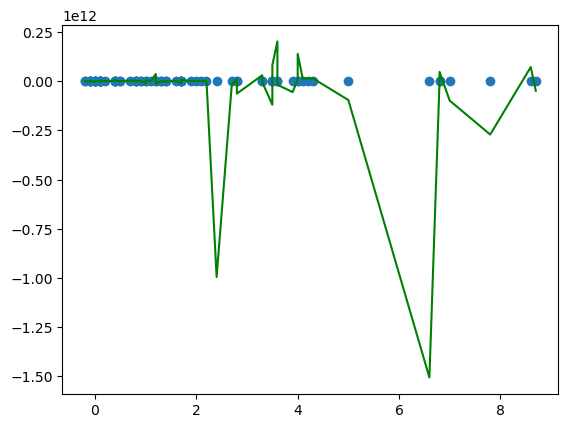


2PA



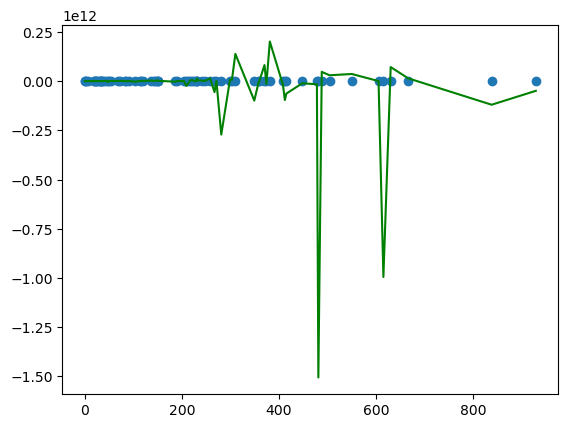


FGA



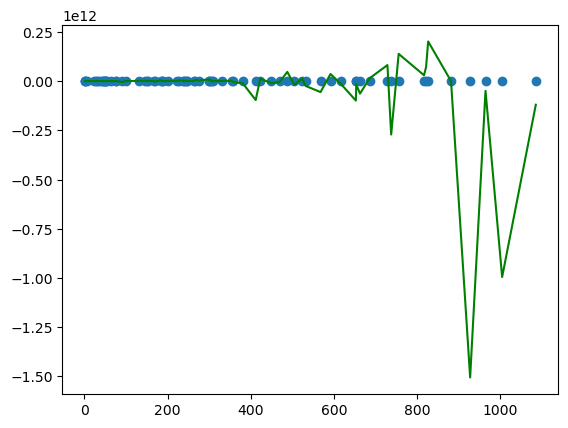


2P



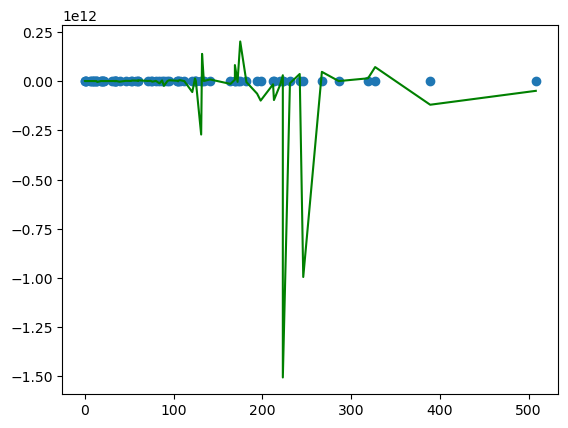


PTS



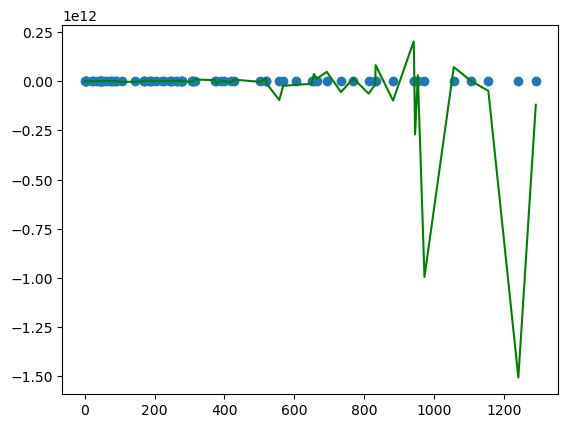


FG



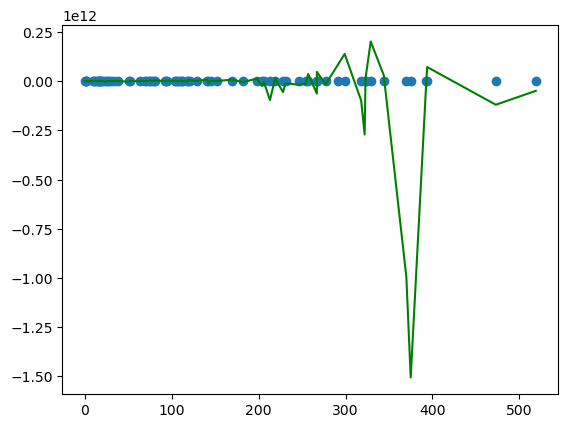

In [22]:
# polynomial regression model to predict salary based on PTS, FTA, 2PA, FGA, WS, GS 
# which were found to have some correlation to salary via heatmap

for i in range(1,5):
    poly = PolynomialFeatures(degree = i, include_bias = False)
    
    x_poly_train = poly.fit_transform(X_salary_train)
    x_poly_test = poly.fit_transform(X_salary_test)
    
    plr = LinearRegression().fit(x_poly_train, y_salary_train)

    train_poly_pred = plr.predict(x_poly_train)
    test_poly_pred = plr.predict(x_poly_test)
    print(f"\nDegree: {i}\nTraining RMSE: {math.sqrt(mean_squared_error(train_poly_pred, y_salary_train))}\nTesting RMSE: {math.sqrt(mean_squared_error(test_poly_pred, y_salary_test))}\nTraining R2: {r2_score(train_poly_pred, y_salary_train)}\nTesting R2: {r2_score(test_poly_pred, y_salary_test)}\n")
    
    for i in X_salary_test:
        print(f"\n{i}\n")
        x_pd = pd.Series(X_salary_test[i].values.flatten())
        y_pred_pd = pd.Series(test_poly_pred.flatten())

        x_sorted = x_pd.sort_values()

        Y_pred = np.array(y_pred_pd[x_sorted.index])
        x_arr = np.array(x_sorted)

        #plotting
        plt.scatter(X_salary_test[i], y_salary_test)
        plt.plot(x_arr, Y_pred, color='g')
        plt.show()

In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

class DenseLayer:
    def __init__(self, neurons):
        # Initialize the layer with the given number of neurons
        self.neurons = neurons
        
    def relu(self, inputs):
        # Implement the ReLU activation function on the given inputs
        return np.maximum(0, inputs)

    def softmax(self, inputs):
        # Implement the softmax activation function on the given inputs
        exp_scores = np.exp(inputs)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    def relu_derivative(self, dA, N):
        # Calculate the derivative of the cost function with respect to the inputs of the layer using the derivative of the ReLU activation function
        # dA is the derivative of the cost function with respect to the output of the layer
        # N is the weighted sum of the inputs to the layer
        # First create a binary vector that is 1 where the input to the ReLU function was positive and 0 where it was negative or zero
        dN = (N <= 0).astype(float)
        # Multiply dN element-wise with dA to obtain the derivative of the cost function with respect to the output of the ReLU function
        return dN * dA
    
    def forward(self, inputs, weights, bias, activation):
        N = (inputs @ weights.T) + bias
        
        if activation == 'relu':
            A = self.relu(N)
        elif activation == 'softmax':
            A = self.softmax(N)
            
        return A, N
    
    def backward(self, dA_curr, W_curr, Z_curr, A_prev, activation):
        if activation == 'softmax':
            dW = A_prev.T @ dA_curr
            db = np.sum(dA_curr, axis=0, keepdims=True)
            dA = dA_curr @ W_curr
        else:
            dZ = self.relu_derivative(dA_curr, Z_curr)
            dW = A_prev.T @ dZ
            db = np.sum(dZ, axis=0, keepdims=True)
            dA = dZ @ W_curr
            
        return dA, dW, db

class Network:
    def __init__(self):
        self.network = []
        self.architecture = []
        self.params = []
        self.memory = []
        self.gradients = []
        
    def add(self, layer):
        self.network.append(layer)
            
    def _compile(self, data):
        for idx, layer in enumerate(self.network):
            if idx == 0:
                self.architecture.append({'input_dim':data.shape[1], 'output_dim':self.network[idx].neurons,
                                         'activation':'relu'})
            elif idx > 0 and idx < len(self.network)-1:
                self.architecture.append({'input_dim':self.network[idx-1].neurons, 'output_dim':self.network[idx].neurons,
                                         'activation':'relu'})
            else:
                self.architecture.append({'input_dim':self.network[idx-1].neurons, 'output_dim':self.network[idx].neurons,
                                         'activation':'softmax'})
        return self
    
    def _init_weights(self, data):
        self._compile(data)
        
        np.random.seed(99)
        
        for layers in self.architecture:
            self.params.append({
                'W':np.random.uniform(low=-1, high=1, size=(layers['output_dim'], layers['input_dim'])),
                'b':np.zeros((1, layers['output_dim']))})
        return self
    
    def _forwardprop(self, data):
        print(data)
        A_curr = data.copy()
        
        for i in range(len(self.params)):
            A_prev = A_curr
            A_curr, Z_curr = self.network[i].forward(inputs=A_prev, weights=self.params[i]['W'], 
                                           bias=self.params[i]['b'], activation=self.architecture[i]['activation'])
            
            self.memory.append({'inputs':A_prev, 'Z':Z_curr})
            
        return A_curr
    
    def _backprop(self, predicted, actual):
        num_samples = len(actual)
        
        dscores = predicted
        dscores[range(num_samples),actual] -= 1
        dscores /= num_samples
        
        dA_prev = dscores
        
        for idx, layer in reversed(list(enumerate(self.network))):
            dA_curr = dA_prev
            
            A_prev = self.memory[idx]['inputs']
            Z_curr = self.memory[idx]['Z']
            W_curr = self.params[idx]['W']
            
            activation = self.architecture[idx]['activation']

            dA_prev, dW_curr, db_curr = layer.backward(dA_curr, W_curr, Z_curr, A_prev, activation)

            self.gradients.append({'dW':dW_curr, 'db':db_curr})
            
    def _update(self, lr=0.01):
        for idx, _ in enumerate(self.network):
            self.params[idx]['W'] -= lr * list(reversed(self.gradients))[idx]['dW'].T  
            self.params[idx]['b'] -= lr * list(reversed(self.gradients))[idx]['db']
    
    def _get_accuracy(self, predicted, actual):
        return np.mean(np.argmax(predicted, axis=1)==actual)
    
    def _calculate_loss(self, predicted, actual):
        samples = len(actual)

        correct_logprobs = -np.log(predicted[range(samples),actual])
        data_loss = np.sum(correct_logprobs)/samples

        return data_loss
    
    def train(self, X_train, y_train, epochs):
        self.loss = []
        self.accuracy = []
        
        self._init_weights(X_train)
        
        for i in range(epochs):
            yhat = self._forwardprop(X_train)
            self.accuracy.append(self._get_accuracy(predicted=yhat, actual=y_train))
            self.loss.append(self._calculate_loss(predicted=yhat, actual=y_train))
            
            self._backprop(predicted=yhat, actual=y_train)
            
            self._update()
            
            if i % 20 == 0:
                s = 'EPOCH: {}, ACCURACY: {}, LOSS: {}'.format(i, self.accuracy[-1], self.loss[-1])
                print(s)

if __name__ == '__main__':
#      def get_data(path):

#         cols = list(data.columns)
#         target = cols.pop()

#         X = data[cols].copy()
#         y = data[target].copy()

#         y = LabelEncoder().fit_transform(y)

#         return np.array(X), np.array(y)


    
    X_new_train = np.array(X_salary_train[:].astype(int))
    y_new_train = np.array(y_salary_train[:].astype(int))
    # X_new_train = X_salary_train.copy()
    # y_new_train = y_salary_train.copy()
    model = Network()
    model.add(DenseLayer(6))
    model.add(DenseLayer(8))
    model.add(DenseLayer(3))
    print(y_salary_train)
    model.train(X_new_train, y_new_train, epochs=200)
    

129    11265416
204     7070730
27       915243
31      3396250
18      3800000
         ...   
178     2380594
212      816482
145      235762
341     3333333
96      5450000
Name: salary, Length: 302, dtype: int64
[[ 202  291    4 ...  452 1313  521]
 [ 315  365   10 ...  421 1628  578]
 [  58   74    2 ...  140  467  183]
 ...
 [  63   78    1 ...  142  533  204]
 [  61   77    2 ...  135  529  201]
 [ 227  252    3 ...  213 1010  332]]


C:\Users\sheep\AppData\Local\Temp\ipykernel_14200\3488255403.py:16: RuntimeWarning: overflow encountered in exp
  exp_scores = np.exp(inputs)
C:\Users\sheep\AppData\Local\Temp\ipykernel_14200\3488255403.py:17: RuntimeWarning: invalid value encountered in divide
  return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)


IndexError: index 11265416 is out of bounds for axis 1 with size 3